In [9]:
!pip install timm

     |████████████████████████████████| 244 kB 864 kB/s eta 0:00:01


In [10]:
!ls ../input/rsna-str-pulmonary-embolism-detection/train

0003b3d648eb  331a8168811c  66b13a0dff35  9a4a563a4d13	cd01c695763d
000f7f114264  3324a7eb9bb2  66b5e1199c99  9a5e9710bae6	cd0441e0188a
00102474a2db  333119b51864  66c6fb92d6ee  9a6b28988474	cd0973feed36
0038fd5f09f5  333494d5edf8  66d22aaea6e4  9a748e31f786	cd0ac16de9ba
0045f113e031  33406254a9f8  66dc6bf4fb34  9a79d21ff53b	cd0b7c2d6b35
004a429fc727  3345f2442e34  66e4ab47ad2b  9a84836bc5ad	cd0f7d6be318
004b06506f54  336631eee64b  66e5c33a2a85  9a98e08ae06d	cd1ccd6e9d50
004f9a1605e7  336b75deb82c  66e7a2394020  9aa9f5181eeb	cd1d5abc8fdf
00511e94edec  33755aec11b2  66f42b441e79  9abaa700c919	cd2314d459c2
005a0dbcb4b7  3377d2d8e2f6  66fdaaf58411  9ac218d1fcfe	cd233817335f
005df0f53614  338e4e685b9f  67074ae2ef97  9ac35ede8178	cd2cbf78dad8
00617c9fe236  338f2ea19017  670a1f671021  9ac82f9aa6b6	cd31ff0cef09
0062c8f4f1a7  339e275f5d07  671144403cb6  9ac9211c648e	cd3758645828
00681a0d8068  339fb552c9ed  671a05e18984  9acd29db816a	cd3a45ab948a
0072baad76be  33a12351d10f  671a765ca478  9adf9d

In [11]:
import os
import gc
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from   torch.nn import CrossEntropyLoss, MSELoss
from   torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
from   torch.nn import Parameter
import math

import fastai
from   fastai.callback.mixup import MixUp, CutMix
from   fastai.callback import *
from   fastai.callback.all import *
from   fastai.callback.training import GradientClip
from   fastai.callback.all import SaveModelCallback, EarlyStoppingCallback, ReduceLROnPlateau 
from   fastai.data.core import *
from   fastai.data.load import *
from   fastai.learner import Learner
from   fastai.metrics import *
from   fastai.optimizer import OptimWrapper 
from   fastai.losses import LabelSmoothingCrossEntropy

# from   warmup_scheduler import GradualWarmupScheduler
from   sklearn import preprocessing
from   sklearn.metrics import accuracy_score
from   sklearn.model_selection import StratifiedKFold, GroupKFold

import timm
import albumentations as A
from   albumentations.pytorch import ToTensorV2
from   albumentations.core.transforms_interface import DualTransform
from   albumentations.augmentations import functional as AF
import cv2

from   tqdm import tqdm
from   pprint import pprint
from   functools import partial
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings ("ignore")

In [12]:
class CFG:
    device       = torch.device ('cuda:0' if torch.cuda.is_available () else 'cpu')
    num_workers  = 4
    model_name   = 'resnet200d' # ['deit_base_patch16_224', 'vit_base_patch16_384', 'resnext50_32x4d', 'tf_efficientnet_b7_ns']
    size         = 512  # [64, 128, 224, 384, 512]
    train        = True
    freeze       = True     # this is updated during training   
    epochs       = 1 
    epochsNx     = 4
    criterion    = 'BCEWithLogitsLoss'    # ['CrossEntropyLoss', 'BCEWithLogitsLoss', 'SmoothBCEwithLogits']
    batch_size   = 10 #[10, 32, 64]
    weight_decay = 1e-6
    grad_norm    = 1
    tta          = 3 
    seed         = 42
    target_size  = -1    # init below
    n_fold       = 5
    train_fold   = [0] #, 1, 2, 3, 4]
    # infer_fold = [0, 1, 2, 3, 4]
    img_ext      = '.png'
    img_col      = "image_id"  # not used
    raw_label_cols = ['pe_present_on_image'] # not used
    label_cols   = ['pe_present_on_image']
    model_infer_path_prefix = "../input/ranzcr-chest-xray-pretrainer" 
    model_train_path_prefix = "."
    train_path   = '../input/rsna-str-pulmonary-embolism-detection/train'
    train_csv    = '../input/rsna-str-pulmonary-embolism-detection/train.csv'
    test_path    = '../input/rsna-str-pulmonary-embolism-detection/test'
    test_csv     = '../input/rsna-str-pulmonary-embolism-detection/test.csv'
    output_dir   = 'Output/'
    prev_target_size = 11     # 14
    freeze_epo   = 1          # after these epochs, gradually unfreeze top layers
    
    smoothing    = 0.1
    min_unfreez_layer = 2     # allowed to unfreeze layers 11 to 5 only and not less than 5
    gradual_unfreez_epo = 7
    IMG_MEAN     = [0.485, 0.456, 0.406] #Mean for normalization Transform cassava = [0.4303, 0.4967, 0.3134] imgnet = [0.485, 0.456, 0.406]
    IMG_STD      = [0.229, 0.224, 0.225] #STD for normalization Transform cassava = [0.2142, 0.2191, 0.1954] imgnet = [0.229, 0.224, 0.225]            
    
CFG.target_size = len (CFG.label_cols)

In [13]:
def init_logger (log_file=CFG.output_dir+'train.log'):
    
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger (__name__)
    logger.setLevel (INFO)
    handler1 = StreamHandler ()
    handler1.setFormatter (Formatter ("%(message)s"))
    handler2 = FileHandler (filename=log_file)
    handler2.setFormatter (Formatter ("%(message)s"))
    logger.addHandler (handler1)
    logger.addHandler (handler2)
    return logger

In [14]:
def seed_everything (seed):
    
    random.seed (seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed (seed)
    torch.manual_seed (seed)
    torch.cuda.manual_seed (seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    return

## Preprocess train.csv

# Not used
def preprocess_train_csv ():
    
    df = pd.read_csv (CFG.train_csv).reset_index (drop=True)
    cols = [CFG.img_col] + CFG.raw_label_cols
    df = df[cols]
    dg = df.groupby (CFG.img_col)
    df_dicts = []
    for k in dg:
        # print (k[0], list(k[1]['class_id']))
        row = {CFG.img_col:k[0]}
        for cat in range(14):
            row[cat] = 0
        for cat in list(k[1]['class_id']):
            if cat != 14:
                row[cat] = 1
        df_dicts.append (row)
    df = pd.DataFrame.from_dict (df_dicts)
    # df.head ()
    return df

# Augmentation Dataset

In [16]:
# NOTE: We don't normalize here since it all gets dark
# if advprop:           # for models using advprop pretrained weights
#     normalize = transforms.Lambda(lambda img: img * 2.0 - 1.0)
# else:
#     normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
train_transforms = A.Compose ([
        A.HorizontalFlip (p=0.5),
        A.Resize (CFG.size, CFG.size),
        ToTensorV2 (p=1.0),
])
valid_transforms = A.Compose ([
        A.Resize (CFG.size, CFG.size),
        ToTensorV2 (p=1.0),
])

def get_transforms (data='train'):
    
    if 'train' in data:
        return train_transforms
    elif 'valid' in data:
        return valid_transforms
    else:
        return valid_transforms

In [ ]:
!pip install pylibjpeg pylibjpeg-libjpeg pydicom
!cp ../input/gdcm-conda-install/gdcm.tar .
!tar -xvzf gdcm.tar
!conda install --offline ./gdcm/gdcm-2.8.9-py37h71b2a6d_0.tar.bz2

import pydicom
from pydicom import dcmread
from scipy.ndimage.interpolation import zoom

In [67]:
def window(img, WL=50, WW=350):
    upper, lower = WL+WW//2, WL-WW//2
    X = np.clip(img.copy(), lower, upper)
    X = X - np.min(X)
    X = X / np.max(X)
    #X = (X*255.0).astype('uint8')
    return X

def get_dcm_img (path):
    
    d = pydicom.read_file (path)
    '''
    res = cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (CFG['img_size'], CFG['img_size'])), d.ImagePositionPatient[2]
    '''
    
    '''
    RED channel / LUNG window / level=-600, width=1500
    GREEN channel / PE window / level=100, width=700
    BLUE channel / MEDIASTINAL window / level=40, width=400
    '''
    
    img = (d.pixel_array * d.RescaleSlope) + d.RescaleIntercept
    
    r = window(img, -600, 1500)
    g = window(img, 100, 700)
    b = window(img, 40, 400)
    
    res = np.concatenate([r[:, :, np.newaxis],
                          g[:, :, np.newaxis],
                          b[:, :, np.newaxis]], axis=-1)
    
    #res = (res*255.0).astype('uint8')
    res = zoom (res, [CFG.size/res.shape[0], CFG.size/res.shape[1], 1.], prefilter=False, order=1)
    #res = cv2.resize(res, (CFG['img_size'], CFG['img_size']))
    #res = res.astype(np.float32)/255.
    
    return res

     |████████████████████████████████| 4.2 MB 988 kB/s eta 0:00:01
     |████████████████████████████████| 3.6 MB 9.1 MB/s eta 0:00:01
gdcm/
gdcm/conda-4.8.4-py37hc8dfbb8_2.tar.bz2
gdcm/gdcm-2.8.9-py37h71b2a6d_0.tar.bz2
gdcm/libjpeg-turbo-2.0.3-h516909a_1.tar.bz2
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [91]:
class ImgDataset (Datasets):
    
    def __init__(self, df, img_file_colname=CFG.img_col, label_cols=CFG.label_cols, # transform=get_transforms(),
                 transform=None, img_dir=CFG.train_path, img_ext=CFG.img_ext):
        
        super (ImgDataset, self).__init__(df.reset_index(drop=True), tfms=None, n_inp=1)
        self.img_ext          = CFG.img_ext
        self.img_dir          = img_dir
        self.label_cols       = label_cols
        self.img_file_colname = img_file_colname
        self.transform        = transform
        return
    
    def __len__(self):
        return self.items.shape[0]    
    
    def __getitem__(self, idx):
        
        # file_name = self.items[self.img_file_colname][idx].replace (self.img_ext, '') + self.img_ext
        file_path = "{}/{}/{}/{}.dcm".format (CFG.train_path, 
                                              self.items.iloc[idx]['StudyInstanceUID'], 
                                              self.items.iloc[idx]['SeriesInstanceUID'], 
                                              self.items.iloc[idx]['SOPInstanceUID'])
        print ('file_path =', file_path)
        # image = cv2.imread (file_path)
        # image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
        # image = get_dcm_img (file_path)
        image = dcmread (file_path).pixel_array.astype (np.int32)   # `image` is a numpy.ndarray
        
        if self.transform:
            image = self.transform (image=image)['image'].float ()
        else:
            image = ToTensorV2 ()(image = image)["image"].float ()
        
        if len (self.label_cols) > 0:
            label = torch.tensor (self.items.loc[idx, self.label_cols]).float () # long ()
            return image, label
        return image

In [92]:
def getFolds ():
    
    train_folds_df = pd.read_csv (CFG.train_csv)
    label = train_folds_df[CFG.label_cols]
    if len (CFG.label_cols) > 1:
        label = train_folds_df[CFG.label_cols[0]]
        
    skf = StratifiedKFold (n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate (skf.split (train_folds_df, label)):
        train_folds_df.loc[val_index, 'fold'] = int (n)
    train_folds_df['fold'] = train_folds_df['fold'].astype (int)
    # print (train_folds_df.groupby (['fold', label]).size ())
        
    return train_folds_df

In [93]:
!ls ../input/rsna-str-pulmonary-embolism-detection/train/2aaa5a9f8639/ab93420bb10d/a8ff2a6d65cb.dcm

../input/rsna-str-pulmonary-embolism-detection/train/2aaa5a9f8639/ab93420bb10d/a8ff2a6d65cb.dcm


file_path = ../input/rsna-str-pulmonary-embolism-detection/train/d8948442bb87/dd5f551b6710/968d77a37a1f.dcm


NameError: name 'int32' is not defined

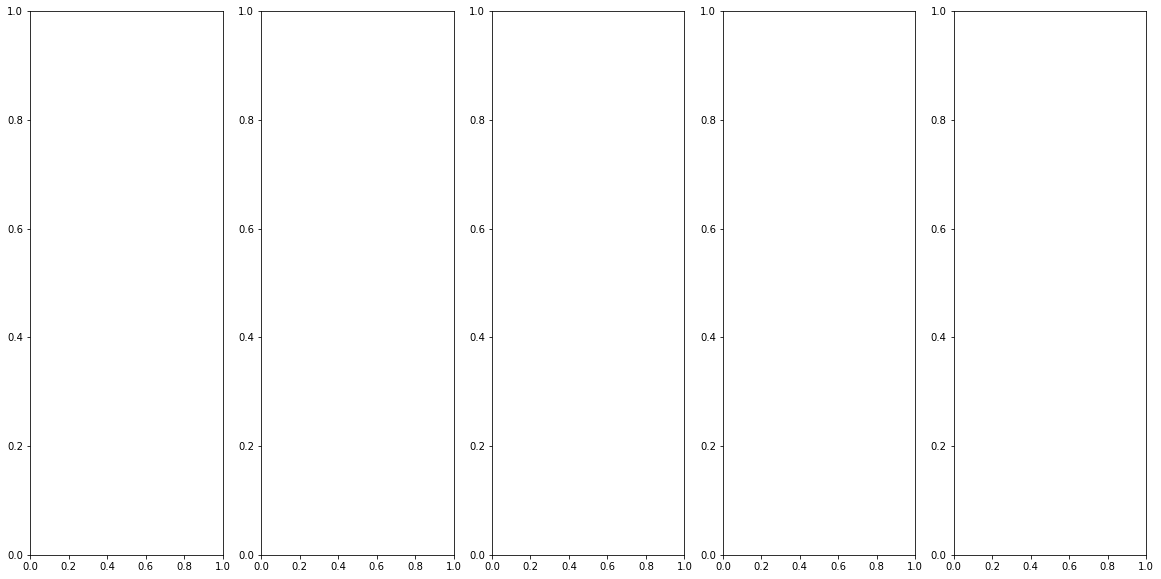

In [94]:
def plot_imgs (dataset_show):
    
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range (2):
        f, axarr = plt.subplots (1,5)
        for p in range (5):
            idx = np.random.randint (0, len (dataset_show))
            img, label = dataset_show[idx]                                    ;print (img.size())
            img = img.byte ()
            axarr[p].imshow (img.permute(1, 2, 0))
            axarr[p].set_title (idx)
    return

TR_DATASET = ImgDataset (getFolds ())
plot_imgs (TR_DATASET)
del TR_DATASET
gc.collect ()

> # Loss Functions

In [72]:
# this works for only 1 label, not multi-label target.
class SmoothBCEwLogits (_WeightedLoss):
    
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [73]:
def get_criterion ():
    
    if CFG.criterion=='CrossEntropyLoss':
        criterion = LabelSmoothingCrossEntropy ()
    elif CFG.criterion=='SmoothBCEwithLogits':
        criterion = SmoothBCEwLogits (smoothing=CFG.smoothing)
    elif CFG.criterion=='BCEWithLogitsLoss':
        criterion =  nn.BCEWithLogitsLoss ()
    return criterion

In [ ]:
# ====================================================
# MODEL
# ====================================================
class CustomResNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear (n_features, CFG.prev_target_size)
        return
    
    def forward(self, x):
        x = self.model (x)
        return x
    
    def freeze (self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.fc.parameters():
            param.requires_grad = True
        return
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
        return
    
class CustomResNext(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.fc.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
            

class CustomEfficientNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model (CFG.model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
        
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.classifier.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
    
    
class CustomDeiT(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/deit:main', model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.head.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True

    
class CustomViT(nn.Module):
    
    def __init__(self, model_name=CFG.model_name, pretrained=False):
                 # min_unfreez_layer=CFG.min_unfreez_layer, max_layer_no=CFG.max_layer_no):
        
        super().__init__()
        self.model      = timm.create_model(model_name, pretrained=pretrained)
        n_features      = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)
        self.min_unfreez_layer = min_unfreez_layer
        self.max_layer_no      = max_layer_no
        return

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.head.parameters():
            param.requires_grad = True
        return
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
        return
    
    # def unfreeze_layer (self, layer_no=11):
    #     # unfreeze a particular layer
    #     if layer_no >= self.min_unfreez_layer and layer_no <= self.max_layer_no:
    #         for param in self.model.blocks[layer_no].parameters ():
    #             param.requires_grad = False
    #     return

In [ ]:
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates (subplots)
def plot_metrics (self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil (n / ncols))
    elif ncols is None: ncols = int(np.ceil (n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots (nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate (axs.flatten())][:n]
    for i, (name, ax) in enumerate (zip (names, [axs[0]] + axs)):
        ax.plot (metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title (name if i > 1 else 'losses')
        ax.legend (loc='best')
    plt.show ()

In [ ]:
@delegates (torch.optim.AdamW.__init__)
def pytorch_AdamW (param_groups, **kwargs):
    return OptimWrapper (torch.optim.AdamW ([{'params': ps, **kwargs} for ps in param_groups]))

In [ ]:
def load_state (model_path, model):
    
    state_dict = None
    try:  # single GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu'))['model']
        # print (state_dict)
        model.load_state_dict (state_dict, strict=True)
    except:  # multi GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu'))
        state_dict = {k[7:] if k.startswith ('module.') else k: state_dict[k] for k in state_dict.keys ()}
        model.load_state_dict (state_dict)
    return state_dict

In [ ]:
class UnfreezeCallback (Callback):
    
    def __init__(self, freeze_epo=CFG.freeze_epo):
        super().__init__()
        self.freeze_epo   = freeze_epo
        return
        
    def before_epoch (self): 
        if self.epoch == self.freeze_epo:
            print ('UnfreezeCallback : unfreezing the model')
            self.learn.model.unfreeze ()

In [ ]:
def getModel (fold, isTrain=True):
    
    model = None
    if 'deit_' in CFG.model_name:
        model = CustomDeiT (model_name=CFG.model_name, pretrained=isTrain)
    elif 'vit_' in CFG.model_name:
        model = CustomViT (model_name=CFG.model_name, pretrained=isTrain)
    elif 'resnext' in CFG.model_name:
        model = CustomResNext (CFG.model_name, pretrained=isTrain)
    elif 'resnet' in CFG.model_name:
        model = CustomResNet (CFG.model_name, pretrained=isTrain)
    elif 'efficientnet' in CFG.model_name:
        model = CustomEfficientNet (CFG.model_name, pretrained=isTrain)      
    if isTrain:
        
        model_path = f'{CFG.model_infer_path_prefix}/{CFG.model_name}_fold{fold}_end.pth'
        # if os.path.exists (model_path):
        print ("loading from", model_path)
        load_state (model_path, model)  
        n_features = model.model.fc.in_features
        model.model.fc = nn.Linear (n_features, CFG.target_size)        
    else:
        
        # TODO: change CFG.model_train_path_prefix to CFG.model_infer_path_prefix
        model_path = f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_maxacc.pth'
        load_state (model_path, model)
        
    if CFG.freeze:        
        model.freeze ()
    else:
        model.unfreeze ()
    return model

In [ ]:
def fit_epochs (fold, callbacks, learn, max_acc, start_lr=1e-6, end_lr=5e-5, model=None):
    
    if model is None:
        model   = getModel (fold, isTrain=True).float().to (CFG.device)
    learn.model = model
    
    # lr_min    = 0.0008
    lr_min, _   = learn.lr_find (start_lr=start_lr, end_lr=end_lr, num_it=100) 
    lr_min      = 2 * lr_min
    print ('lr_min =', lr_min)
    lr          = lr_min
    learn.fit_one_cycle (CFG.epochs, lr, wd=CFG.weight_decay, cbs=callbacks)
    learn.recorder.plot_metrics ()
    # learn.recorder.plot_lr ()        
    acc = learn.recorder.metrics[0].value.numpy ()
    if acc > max_acc:
        max_acc = acc
        print ("Saving Max-Acc model.....")
        learn.save (f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_maxacc')
    learn.save (f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_end')
    return max_acc

In [ ]:
def train_fold_loop (fold, train_df=getFolds ()):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = train_df[train_df['fold'] != fold].index
    val_idx = train_df[train_df['fold'] == fold].index
    train_folds_df = train_df.loc[trn_idx].reset_index (drop=True)
    valid_folds_df = train_df.loc[val_idx].reset_index (drop=True)    
    loss_func      = get_criterion ()
    model          = getModel (fold, isTrain=True)
    model          = model.float().to (CFG.device)
    modelfile      = f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}'
    train_dataset  = ImgDataset (train_folds_df, transform=get_transforms ('train'))
    valid_dataset  = ImgDataset (valid_folds_df, transform=get_transforms ('valid'))
    train_datlder  = DataLoader (train_dataset, batch_size=CFG.batch_size, device=CFG.device)
    valid_datlder  = DataLoader (valid_dataset, batch_size=CFG.batch_size, device=CFG.device)
    dls            = DataLoaders (train_datlder, valid_datlder, device=CFG.device)
    metrics        = [accuracy, error_rate]    # fbeta, auc_roc_score 
    if len (CFG.label_cols) > 1:
        metrics    = [accuracy_multi, accuracy_multi]
    learn          = Learner (dls, model, loss_func=loss_func, model_dir=f'{CFG.model_train_path_prefix}',
                     opt_func=partial (pytorch_AdamW, lr=0.007, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01),
                     metrics=metrics)
    print (learn.summary ())
    
    # initially cfg.freeze=True, but only for the 1st time, at end it is =False to train the deep layers
    max_acc = 0
    for i in range (CFG.epochsNx):
        
        if i < 2:            
            start_lr, end_lr = 1e-4, 5e-3
        else:            
            start_lr, end_lr = 1e-5, 1e-3
        
        callbacks = [
            EarlyStoppingCallback (monitor='accuracy_multi', min_delta=0.001, patience=3), # useless now
            SaveModelCallback     (monitor='accuracy_multi', fname=modelfile),             # useless now
            ReduceLROnPlateau     (monitor='accuracy_multi', min_delta=0.001, factor=2.0, min_lr=1e-8, patience=1),
            GradientClip (CFG.grad_norm),
        ]
        if i==0:
            callbacks.append (UnfreezeCallback ())
            
        # For fine tuning don't pass the model
        # model = model.to ('cpu'); del model; gc.collect ()        
        # max_acc = fit_epochs (fold, callbacks, learn, max_acc, start_lr, end_lr)
        
        # For pre-training pass the model
        max_acc = fit_epochs (fold, callbacks, learn, max_acc, start_lr, end_lr, model)
        
        if i==0:
            CFG.freeze = False
            print ("Unfreezing the model !")
            model.unfreeze ()
            
    valid_scores = learn.validate (dl=valid_datlder)
    return valid_scores

In [ ]:
def train_main ():
    
    if CFG.train:
        
        valid_scores = []
        for fold in range (CFG.n_fold):
            if fold in CFG.train_fold:
                valid_scores_fold = train_fold_loop (fold)
                valid_scores_fold = np.array (valid_scores_fold).reshape ((1, -1))
                valid_scores.append (valid_scores_fold)
                
        LOGGER.info (f"========== CV ==========")
        valid_scores = np.vstack (valid_scores)
        valid_scores = np.mean (valid_scores, axis=0)
        print ("CV Scores =", valid_scores)

In [ ]:
!mkdir -p /kaggle/working/Output/
!touch /kaggle/working/Output/train.log
gc.collect ()
# model_names = timm.list_models (pretrained=True)
# model_names = timm.list_models ('*resnet*', pretrained=True)
# pprint (model_names)

LOGGER = init_logger ()
seed_everything (seed=CFG.seed)
train_main ()

# Inference

In [ ]:
def compute_metrics (labels, preds):
    
    # preds   = pred_pr.argmax (-1)             # ;print ('labels.shape=', labels.shape, 'preds.shape=', preds.shape, 'pred_logits.shape=', pred_logits.shape)
    precision, recall, f1, _ = precision_recall_fscore_support (labels, preds, average='macro')
    acc     = accuracy_score (labels, preds)
    mcc     = matthews_corrcoef (labels, preds)   # matthews correlation coefficient
    # softmax = nn.Softmax (dim=1)
    # pred_pr = softmax (torch.tensor (pred_logits))
    # auc     = roc_auc_score (labels, pred_pr[:, 1])
    metrics = {
        'mcc'      : mcc,
        'accuracy' : acc,
        'f1'       : f1,
        'precision': precision,
        'recall'   : recall,
        #'auc'     : auc
    }
    return metrics

In [ ]:
class TorchImgDataset (torch.utils.data.Dataset):
    
    def __init__(self, df, img_file_colname=CFG.img_col, label_cols=[], 
                 transform=get_transforms('valid'), img_dir=CFG.test_path, img_ext=CFG.img_ext):
        
        super ().__init__()
        self.df               = df.reset_index (drop=True)
        self.img_ext          = CFG.img_ext
        self.img_dir          = img_dir
        self.label_cols       = label_cols
        self.img_file_colname = img_file_colname
        self.transform        = transform
        return
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        
        file_name = self.items[self.img_file_colname][idx] + self.img_ext
        file_path = f'{self.img_dir}/{file_name}'
        image     = cv2.imread (file_path)
        image     = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform (image=image)['image'].float ()
        else:
            image = ToTensorV2 ()(image = image)["image"].float ()
        
        if len (self.label_cols) > 0:
            label = torch.tensor (self.items.loc[idx, self.label_cols]).float () # long ()
            return image, label
        return image

In [ ]:
def inference_one_loop (model, data_loader, device):
    model.eval ()
    image_preds_all = []
    pbar = tqdm (enumerate (data_loader), total=len (data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to (device).float ()
        
        image_preds = model (imgs) 
        image_preds_all += [torch.sigmoid (image_preds).detach ().cpu ().numpy ()]
    
    image_preds_all = np.concatenate (image_preds_all, axis=0)
    return image_preds_all

In [ ]:
def infer ():
    
    CFG.freeze = True
    tst_preds_avg = []    
    seed_everything (CFG.seed)
    test_df = pd.DataFrame ()
    test_df[CFG.img_col] = list (os.listdir (CFG.test_path))
    test_ds = TorchImgDataset (test_df, label_cols=[], transform=get_transforms('valid'), img_dir=CFG.test_path)             #;print ('len (test_ds) =', len (test_ds)) ;print ('test_ds[10].shape =', test_ds[10].shape)
    tst_loader = torch.utils.data.DataLoader (
        test_ds, 
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=False,
        pin_memory=False,
    )                                            #;print ('len (tst_loader)=', len (tst_loader))
    for fold in CFG.train_fold:
        
        print ('Inference fold {} started'.format (fold))
        model     = getModel (fold, isTrain=False).to (CFG.device)
        tst_preds = []        
        with torch.no_grad ():
            for _ in range (CFG.tta):
                
                tst_preds += [1/CFG.tta * inference_one_loop (model, tst_loader, CFG.device)]
        
        tst_preds_avg.append (np.mean (tst_preds, axis=0))
        del model
        torch.cuda.empty_cache ()
        gc.collect ()
    
    test_df['label'] = np.argmax (np.mean (tst_preds_avg, axis=0), axis=-1)
    print (test_df.head ())
    test_df.to_csv ('submission.csv', index=False)

In [ ]:
print ('Done !')